# IMPORTS

In [505]:
# \\  -------- IMPORTS -------- //

from ast import Return
from codecs import getdecoder
from pkgutil import get_data
from typing import List
from unicodedata import name
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt



import backtrader as bt
import talib

# cyclical imports
from statsmodels.tsa.filters.hp_filter import hpfilter


# for outliers in data cleaning
from scipy import stats

# Data API
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

df = 0
df1 = 0

end = dt.datetime.now()  # end date is now
start = dt.datetime(1980, 1, 1)   # start date 


# IMPORTING DATA

In [713]:
# import asset data
data = yfin.download(("SPY", '^FTSE', 'DX-Y.NYB', 'CL=F', 'GBPUSD=X', 'EURUSD=X', 'BTC-USD', 'SB=F'), start="2004-01-01", end= dt.datetime.now())

data_1 = pd.DataFrame(data["Close"])

# clean the data

df_asset = data_1.asfreq('D')

df_asset = df_asset.interpolate(method = 'linear') # fill gaps to the correct frequency

df_asset = df_asset.fillna(method = 'ffill')

df_asset = df_asset.fillna(method = 'backfill')

df_asset = df_asset[(np.abs(stats.zscore(df_asset)) < 10).all(axis=1)] # remove any extreme outliers

[*********************100%***********************]  8 of 8 completed


# SELECT ASSET

In [643]:
# select Asset
asset = 'GBPUSD=X'

In [644]:
df_asset[asset].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 7049 entries, 2004-01-01 to 2023-04-19
Freq: D
Series name: GBPUSD=X
Non-Null Count  Dtype  
--------------  -----  
7049 non-null   float64
dtypes: float64(1)
memory usage: 368.2 KB


<AxesSubplot:xlabel='Date'>

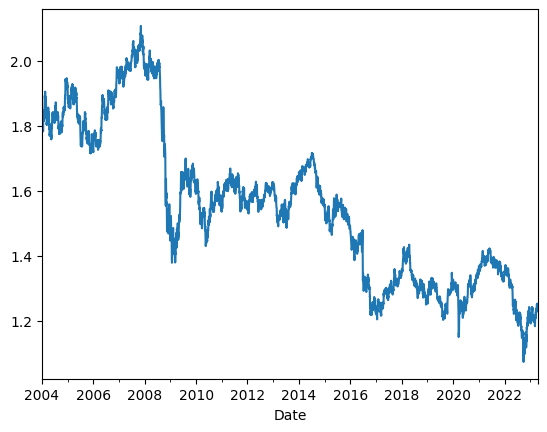

In [645]:
df_asset[asset].plot()

# Calculating Indicators

In [646]:
##########################################################################################################
# creating ROC indicators
# correlation of Weekly ROC
Fortnitely_roc = df_asset[asset].diff(periods=15)

# correlation of Monthly ROC
monthly_roc = df_asset[asset].diff(periods=30)

# correlation of Quarterly ROC
quarterly_roc = df_asset[asset].diff(periods=90)

# correlation of 6M ROC
half_year_roc = df_asset[asset].diff(periods=180)

# correlation of Yearly ROC
yearly_roc = df_asset[asset].diff(periods=365)

Rate_of_Change_data = pd.concat([Fortnitely_roc, monthly_roc, quarterly_roc, half_year_roc, yearly_roc], axis=1)

new_columns = ['Fortnitely_roc', 'Monthly_roc', 'Quarterly_roc', 'Half_year_roc', 'Yearly_roc']
Rate_of_Change_data.columns = new_columns
############################################################################################################
# Volatility Indicators

#create empty DataFrame
volatility_data = pd.DataFrame()

weekly_returns = df_asset[asset].pct_change().dropna()

Window = 15 
volatility_data['V_Fortnitely'] = weekly_returns.rolling(Window).std()
Window_2 = 30
volatility_data['V_Monthly'] = weekly_returns.rolling(Window_2).std()
Window_3 = 60
volatility_data['V_2_Monthly'] = weekly_returns.rolling(Window_3).std()
Window_4 = 90
volatility_data['V_Quarterly'] = weekly_returns.rolling(Window_4).std()
Window_5 = 180
volatility_data['V_Half_Year'] = weekly_returns.rolling(Window_5).std()
Window_6 = 365
volatility_data['V_Year'] = weekly_returns.rolling(Window_6).std()

# ALL INDICATORS IN 1 DATAFRAME

# what relationship - correlation / stationary ?
indicators_df = pd.concat([volatility_data, Rate_of_Change_data], axis=1)


# METHODS OF CHOOSING APPROPRIATE INDICATOR / INDICATORS FOR ASSET

## FINDING THE ROC INDICATOR AND VOLATILITY INDICATOR

In [647]:

# ROC INDICATOR
##############################################################################
# concat indicators with asset

asset_ind = pd.concat([Rate_of_Change_data, df_asset[asset].diff()], axis = 1)

# calculate the correlation
asset_ind_corr = asset_ind.corr()

# extract the column with the asset
corr_coeff = asset_ind_corr[asset]

#sort the values and remove the top row
corr_coeff = pd.DataFrame(corr_coeff)
corr_coeff = corr_coeff.sort_values(by = asset, ascending = False)
corr_coeff = corr_coeff.iloc[1:]

indicator_roc = corr_coeff.index[0]
print('ROC Indicator used:', indicator_roc)

# VOL INDICATOR
##############################################################################
# concat indicators with asset

asset_ind_vol = pd.concat([volatility_data, df_asset[asset].diff()], axis = 1)

# calculate the correlation
asset_ind_vol_corr = asset_ind_vol.corr()

# extract the column with the asset
corr_coeff_vol = asset_ind_vol_corr[asset]

#sort the values and remove the top row
corr_coeff_vol = pd.DataFrame(corr_coeff_vol)
corr_coeff_vol = corr_coeff_vol.sort_values(by = asset, ascending = False)
corr_coeff_vol = corr_coeff_vol.iloc[1:]
corr_coeff_vol
#print(corr_coeff_vol)
# Calculate the absolute difference from 1 and -1 for each value
abs_diff_1 = abs(corr_coeff_vol - 1)
abs_diff_minus_1 = abs(corr_coeff_vol + 1)
# Find the minimum absolute difference for each column
min_abs_diff = pd.concat([abs_diff_1.min(), abs_diff_minus_1.min()], axis=1).min(axis=1)

indicator_vol = corr_coeff_vol.index[0]
indicator_vol
print('VOL Indicator used:', indicator_vol)

ROC Indicator used: Fortnitely_roc
VOL Indicator used: V_Year


# CREATE THE RULE

## FIND THRESHOLD FOR VOLATILITY

In [648]:
#transform the data
volatility_ind = volatility_data[indicator_vol]
roc_ind = Rate_of_Change_data[indicator_roc]

# mechanism for finding data point to start at where no NaNs appear from the different rates of the indicators

# count how many nans in roc
roc_null = roc_ind.isnull().sum()
#count how many nans in volatility_data
vol_null = volatility_ind.isnull().sum()
#find the biggest an take that many rows off the start off both them

# create empty val
remove = 0
if roc_null > vol_null:
    remove = roc_null
else:
    remove = vol_null

roc_ind = roc_ind[remove:]
vol_ind = volatility_ind[remove:]
returns = df_asset[asset].diff()
returns = returns[remove + 1:]


# CHOOSE AMOUNT OF DATA WITH TAIL
# transform data
volatility_array = vol_ind.to_numpy()
# transform data
returns_array = returns.to_numpy()

### DECISION TREE FOR VOLATILITY THRESHOLD

In [649]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


n = 1000


# Split the data into training and testing sets
split_idx = int(n * 0.8)
train_returns, test_returns = returns_array[:split_idx], returns_array[split_idx:]
train_volatility, test_volatility = volatility_array[:split_idx], volatility_array[split_idx:]

# Fit decision tree to find best threshold for separating positive and negative returns
tree = DecisionTreeRegressor(max_depth=1, random_state=0)
tree.fit(train_volatility.reshape(-1, 1), train_returns)

# Extract threshold from decision tree
threshold = tree.tree_.threshold[0]

# Make predictions on test data
test_predictions = (test_volatility > threshold).astype(int)

# Compute evaluation metrics
accuracy = accuracy_score(test_returns > 0, test_predictions)
precision = precision_score(test_returns > 0, test_predictions)
recall = recall_score(test_returns > 0, test_predictions)
f1 = f1_score(test_returns > 0, test_predictions)

# Print evaluation metrics
print("Threshold for positive returns:", threshold)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Threshold for positive returns: 0.005227288696914911
Accuracy: 0.5222637661454793
Precision: 0.5166444740346205
Recall: 0.27123383432366305
F1 score: 0.3557185422874169


## INDICATOR ENVIRONMENTS

CURRENT: condition_2
ROC 0.0018857717514038086
VOL 0.006242763272053649


<AxesSubplot:xlabel='Date'>

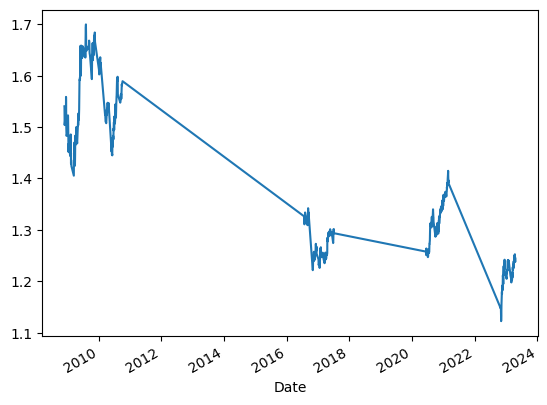

In [651]:
# THE INDICATOR RULE
# Define the rule
condition_1_data = df_asset[asset][(indicators_df[indicator_roc] > 0) & (volatility_ind < threshold)]
condition_2_data = df_asset[asset][(indicators_df[indicator_roc] > 0) & (volatility_ind > threshold)]
condition_3_data = df_asset[asset][(indicators_df[indicator_roc] < 0) & (volatility_ind < threshold)]
condition_4_data = df_asset[asset][(indicators_df[indicator_roc] < 0) & (volatility_ind > threshold)]



condition = ''

if (indicators_df[indicator_roc].tail(1).item() > 0) & (volatility_ind.tail(1).item() < threshold):
    condition = 'CURRENT: condition_1'
    print(condition)
elif (indicators_df[indicator_roc].tail(1).item() > 0) & (volatility_ind.tail(1).item() > threshold):
    condition = 'CURRENT: condition_2'
    print(condition)
elif (indicators_df[indicator_roc].tail(1).item() < 0) & (volatility_ind.tail(1).item() < threshold):
    condition = 'CURRENT: condition_3'
    print(condition)
else:
    condition = 'CURRENT: condition_4'
    print(condition)


print('ROC', indicators_df[indicator_roc].tail(1).item())
print('VOL', volatility_ind.tail(1).item())

# THE INDICATOR RULE
condition_2_data.plot() #= df_asset[asset][(indicators_df['Yearly_roc'] < -0.2)]
#sell_data.plot()

In [701]:
# AVERAGE NUMBER OF CONSECUTIVE DAYS FOR SIGNAL
buy_data_freq = condition_1_data.asfreq('D')
#buy_data_freq
# initialize variables
consec_counts = []
consec_count = 0
for val in buy_data_freq:
    if pd.notnull(val):
        # if value is not null, increment the count
        consec_count += 1
    else:
        # if value is null, append the current count to the list and reset the count
        if consec_count > 0:
            consec_counts.append(consec_count)
            consec_count = 0

# append the final count to the list if necessary
if consec_count > 0:
    consec_counts.append(consec_count)

# calculate the average of the consecutive counts
if len(consec_counts) > 0:
    avg_consec_count = sum(consec_counts) / len(consec_counts)
else:
    avg_consec_count = 0

# print the average number of consecutive non-null values
print(avg_consec_count)

8.967509025270758


In [653]:
# THE INDICATOR RULE
#buy_data = df_asset[asset][(indicators_df['Yearly_roc'] > -0)]

#
# CREATING THE RETURNS
cond_1_perf = ((condition_1_data - condition_1_data.shift(1)) / condition_1_data.shift(1))
cond_2_perf = ((condition_2_data - condition_2_data.shift(1)) / condition_2_data.shift(1))
cond_3_perf = ((condition_3_data - condition_3_data.shift(1)) / condition_3_data.shift(1))
cond_4_perf = ((condition_4_data - condition_4_data.shift(1)) / condition_4_data.shift(1))

# convert date column to datetime format
cond_1_perf['date'] = pd.to_datetime(cond_1_perf.index)
cond_2_perf['date'] = pd.to_datetime(cond_2_perf.index)
cond_3_perf['date'] = pd.to_datetime(cond_3_perf.index)
cond_4_perf['date'] = pd.to_datetime(cond_4_perf.index)

cond_1_perf = pd.DataFrame(cond_1_perf)
cond_2_perf = pd.DataFrame(cond_2_perf)
cond_3_perf = pd.DataFrame(cond_3_perf)
cond_4_perf = pd.DataFrame(cond_4_perf)

cond_1_perf['date'] = cond_1_perf.index
cond_2_perf['date'] = cond_2_perf.index
cond_3_perf['date'] = cond_3_perf.index
cond_4_perf['date'] = cond_4_perf.index

cond_1_perf = cond_1_perf.drop(cond_1_perf.index[-1])
cond_2_perf = cond_2_perf.drop(cond_2_perf.index[-1])
cond_3_perf = cond_3_perf.drop(cond_3_perf.index[-1])
cond_4_perf = cond_4_perf.drop(cond_4_perf.index[-1])

cond_1_perf['date'] = pd.to_datetime(cond_1_perf['date'])
cond_2_perf['date'] = pd.to_datetime(cond_2_perf['date'])
cond_3_perf['date'] = pd.to_datetime(cond_3_perf['date'])
cond_4_perf['date'] = pd.to_datetime(cond_4_perf['date'])

cond_1_perf['diff'] = (cond_1_perf['date'] - cond_1_perf['date'].shift(1)).dt.days != 1
cond_2_perf['diff'] = (cond_2_perf['date'] - cond_2_perf['date'].shift(1)).dt.days != 1
cond_3_perf['diff'] = (cond_3_perf['date'] - cond_3_perf['date'].shift(1)).dt.days != 1
cond_4_perf['diff'] = (cond_4_perf['date'] - cond_4_perf['date'].shift(1)).dt.days != 1

# filter out the rows where the diff column is True
cond_1_perf = cond_1_perf.loc[~cond_1_perf['diff'], ['date', asset]]
cond_2_perf = cond_2_perf.loc[~cond_2_perf['diff'], ['date', asset]]
cond_3_perf = cond_3_perf.loc[~cond_3_perf['diff'], ['date', asset]]
cond_4_perf = cond_4_perf.loc[~cond_4_perf['diff'], ['date', asset]]

#drop date column 
cond_1_perf = cond_1_perf.drop('date', axis = 1)
cond_2_perf = cond_2_perf.drop('date', axis = 1)
cond_3_perf = cond_3_perf.drop('date', axis = 1)
cond_4_perf = cond_4_perf.drop('date', axis = 1)

# replace with incrementing numbers so its all consecutive
cond_1_perf = cond_1_perf.reset_index(drop=True)
cond_2_perf = cond_2_perf.reset_index(drop=True)
cond_3_perf = cond_3_perf.reset_index(drop=True)
cond_4_perf = cond_4_perf.reset_index(drop=True)

# calculate avg return
cond_1_perf_avg = cond_1_perf.mean() * 100
cond_2_perf_avg = cond_2_perf.mean() * 100
cond_3_perf_avg = cond_3_perf.mean() * 100
cond_4_perf_avg = cond_4_perf.mean() * 100

#convert to float
cond_1_perf_avg = float(cond_1_perf_avg)
cond_2_perf_avg = float(cond_2_perf_avg)
cond_3_perf_avg = float(cond_3_perf_avg)
cond_4_perf_avg = float(cond_4_perf_avg)

print('CONDITION 1:', cond_1_perf_avg)
print('CONDITION 2:', cond_2_perf_avg)
print('CONDITION 3:', cond_3_perf_avg)
print('CONDITION 4:', cond_4_perf_avg)

CONDITION 1: 0.035075616365673905
CONDITION 2: 0.06508873780350065
CONDITION 3: -0.05185251933587176
CONDITION 4: -0.07376222059506009


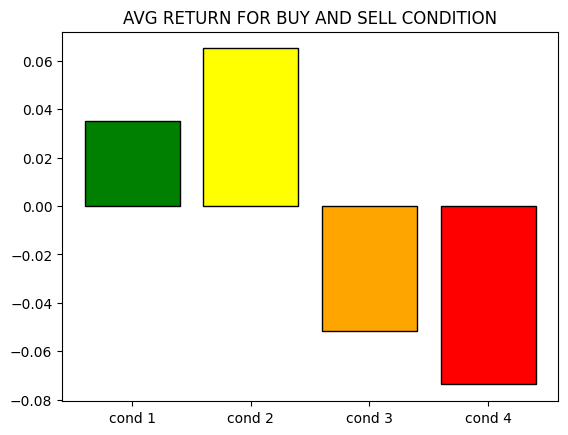

CURRENT CONDITION:  CURRENT: condition_2


In [654]:
# ASSETS PERFORMANCE IN EACH QUAD BAR CHART
# create sample data
categories = ['cond 1', 'cond 2', 'cond 3', 'cond 4']
values = [cond_1_perf_avg, cond_2_perf_avg, cond_3_perf_avg, cond_4_perf_avg]

# create the plot
plt.bar(categories, values, color=['green', 'yellow', 'orange', 'red'], edgecolor='black')

# add x-axis ticks and labels
plt.xticks(categories)

# add a title
plt.title('AVG RETURN FOR BUY AND SELL CONDITION')

# display the plot
plt.show()
print('CURRENT CONDITION: ', condition)

Sharpe Ratio: 1.6150039632652737


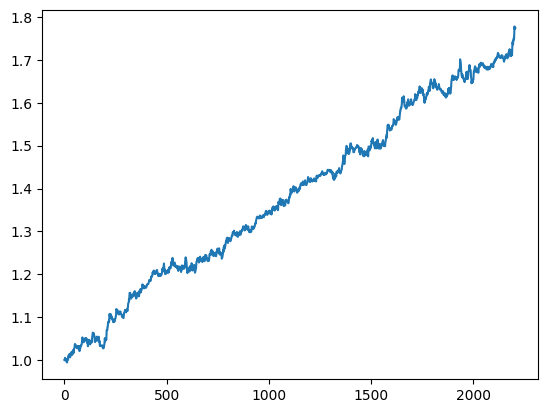

In [655]:
# EQUITY CURVE
#buy_perf.plot()

#cumulative returns
cond_1_perf['cumulative_returns'] = np.cumsum(cond_1_perf[asset]) + 1
cond_2_perf['cumulative_returns'] = np.cumsum(cond_2_perf[asset]) + 1
cond_3_perf['cumulative_returns'] = np.cumsum(cond_3_perf[asset]) + 1
cond_4_perf['cumulative_returns'] = np.cumsum(cond_4_perf[asset]) + 1

cond_1_perf['cumulative_returns'].plot()

# SHARPE RATIO
# Calculate daily returns
daily_returns = cond_1_perf['cumulative_returns'].pct_change()

# Calculate average daily return and standard deviation of daily return
avg_daily_return = daily_returns.mean()
std_daily_return = daily_returns.std()

# Calculate Sharpe Ratio
sharpe_ratio = np.sqrt(252) * (avg_daily_return / std_daily_return)

print("Sharpe Ratio:", sharpe_ratio)

C:\Users\Christopher!\AppData\Local\Temp\ipykernel_25944\2523366586.py:6: RuntimeWarning: divide by zero encountered in true_divide
  drawdown = (cumulative_returns - peak) / peak
C:\Users\Christopher!\AppData\Local\Temp\ipykernel_25944\2523366586.py:6: RuntimeWarning: invalid value encountered in true_divide
  drawdown = (cumulative_returns - peak) / peak


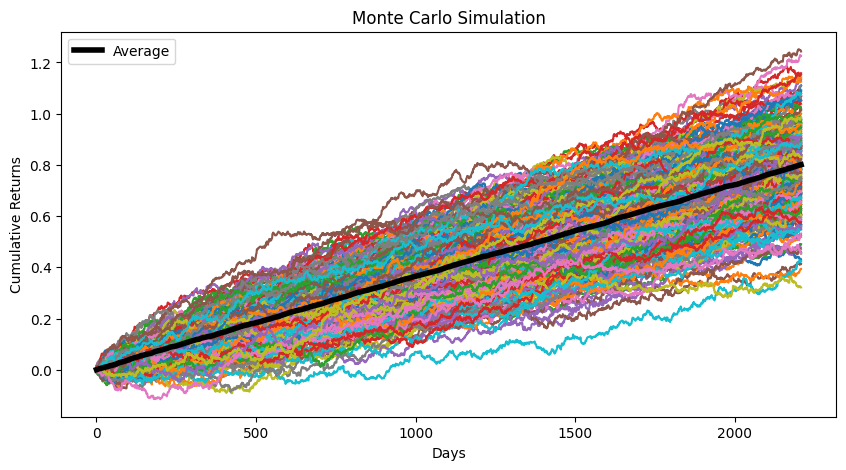

Total Trades: 2207
Number of Simulations: 300
End Performance (mean): 1.22
End Performance (max): 2.42
End Performance (min): 0.36
Win Rate (mean): 52.47%
Win Rate (max): 56.09%
Win Rate (min): 49.12%
Max Drawdown (long positions): -195.19%
Avg Drawdown (long positions): -5.47%
Max Drawup (short positions): 347535054.48%
Avg Drawup (short positions): 68320715.90%
Sharpe Ratio: 4.72
Sortino Ratio: 2538.99


In [656]:
# MONTE CARLO TEST

# function to calculate drawdowns in percentage terms
def calculate_drawdowns_pct(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    return drawdown

# monte carlo performance of asset curve in environment
################################
returns = cond_1_perf[asset]
#################################


# define parameters
num_simulations = 300
trades_per_simulation = len(returns)
end_performance = np.zeros(num_simulations)
win_rates = np.zeros(num_simulations)
max_peak = np.zeros(num_simulations)
avg_peak = np.zeros(num_simulations)

# run monte carlo simulation
simulated_returns = np.zeros((num_simulations, trades_per_simulation))
for i in range(num_simulations):
    sample_returns = returns.sample(n=trades_per_simulation, replace=True)
    cumulative_returns = np.cumprod(1 + sample_returns) - 1
    end_performance[i] = cumulative_returns.iloc[-1]
    win_rates[i] = np.sum(sample_returns > 0) / trades_per_simulation
    
    # calculate cumulative returns for 30 days
    returns_30_days = sample_returns.iloc[:30]
    cumulative_returns_30_days = np.cumprod(1 + returns_30_days) - 1
    avg_cumulative_return_30_days = np.mean(cumulative_returns_30_days)
    
    # calculate cumulative returns for 90 days
    returns_90_days = sample_returns.iloc[:90]
    cumulative_returns_90_days = np.cumprod(1 + returns_90_days) - 1
    avg_cumulative_return_90_days = np.mean(cumulative_returns_90_days)
    
    simulated_returns[i,:] = np.cumsum(sample_returns)

# calculate average simulation curve
mean_cumulative_returns = np.mean(simulated_returns, axis=0)

# calculate drawdowns for each simulation
simulated_drawdowns = np.apply_along_axis(calculate_drawdowns_pct, 1, simulated_returns)

# calculate drawdowns for long positions
cum_returns = np.cumprod(1 + returns) - 1
high_watermark = np.maximum.accumulate(cum_returns)
drawdown = (cum_returns - high_watermark) / np.maximum(high_watermark, 1e-8)
max_drawdown = np.min(drawdown)
avg_drawdown = np.mean(drawdown)

# calculate drawups for short positions
cum_returns = np.cumprod(1 - returns) - 1  # take the opposite of sample returns
low_watermark = np.minimum.accumulate(cum_returns)  # replace maximum with minimum
drawup = (cum_returns - low_watermark) / np.maximum(low_watermark, 1e-8)  # replace drawdown with drawup
max_drawup = np.max(drawup)  # replace min with max
avg_drawup = np.mean(drawup)  # use the mean function as is

# calculate Sharpe ratio
daily_returns = returns.mean() / returns.std()
sharpe_ratio = np.sqrt(trades_per_simulation) * daily_returns

# calculate Sortino ratio
downside_returns = returns.where(returns < 0, 0)
downside_std = downside_returns.std()
sortino_ratio = np.sqrt(trades_per_simulation) * daily_returns / downside_std


# plot results
fig, ax = plt.subplots(figsize=(10,5))
for i in range(num_simulations):
    ax.plot(range(1, trades_per_simulation+1), simulated_returns[i,:])
ax.plot(range(1, trades_per_simulation+1), mean_cumulative_returns, linewidth=4, color='k', label='Average')
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Monte Carlo Simulation')
ax.legend()
plt.show()

# print statistics
print(f"Total Trades: {trades_per_simulation}")
print(f"Number of Simulations: {num_simulations}")
print(f"End Performance (mean): {np.mean(end_performance):.2f}")
print(f"End Performance (max): {np.max(end_performance):.2f}")
print(f"End Performance (min): {np.min(end_performance):.2f}")
print(f"Win Rate (mean): {np.mean(win_rates)*100:.2f}%")
print(f"Win Rate (max): {np.max(win_rates)*100:.2f}%")
print(f"Win Rate (min): {np.min(win_rates)*100:.2f}%")
print(f"Max Drawdown (long positions): {max_drawdown:.2%}")
print(f"Avg Drawdown (long positions): {avg_drawdown:.2%}")
print(f"Max Drawup (short positions): {max_drawup:.2%}")
print(f"Avg Drawup (short positions): {avg_drawup:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")


# CYCLICAL INDICATOR

## BUILD THE CYCLE MODEL

Vol Threshold limit 135.30811735555136


<AxesSubplot:xlabel='Date'>

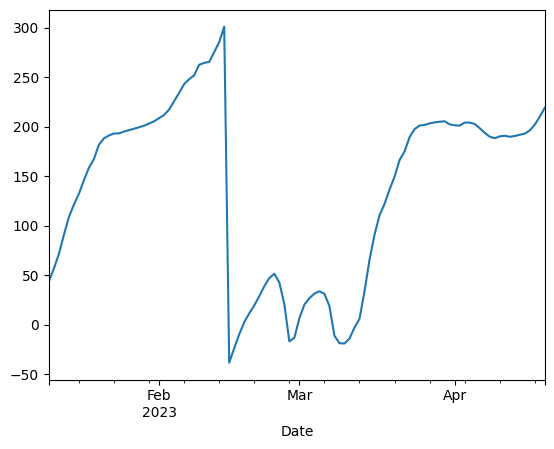

In [657]:
import talib

prices = []

prices = df_asset[asset]

prices = pd.DataFrame(prices)

prices['log_return'] = df_asset[asset].apply(np.log).diff()
#.apply(np.log)
#The first step is to find the dominant phase of the time series using the Hilbert Transform, then use it to model a cycle inefficiency in the market.

#Next is the dominant cycle period which is a signal processing technique that isolates the most significant patterns in prices.

# Hilbert Transform - Dominant Cycle Phase
prices["phase"] = talib.HT_DCPHASE(prices[asset])

#threshold for buy and sell rule
median_phase = prices['phase'].median()
print('Vol Threshold limit', median_phase)

prices['phase'].tail(100).plot()

### INDICATOR RULES AND CURRENT CONDITION

In [659]:
cycle_buy_data = df_asset[asset][prices['phase'] < median_phase]
cycle_sell_data = df_asset[asset][prices['phase'] > median_phase]

condition_2 = ''

if prices['phase'].tail(1).item() < median_phase:
    condition_2 = 'CURRENT: condition_buy'
    print(condition_2)

else:
    condition_2 = 'CURRENT: condition_sell'
    print(condition_2)



CURRENT: condition_sell


In [660]:
# AVERAGE NUMBER OF CONSECUTIVE DAYS FOR SIGNAL
cycle_buy_data_freq = cycle_buy_data.asfreq('D')
cycle_sell_data_freq = cycle_sell_data.asfreq('D')

def get_avg_consec_count(cycle_data_freq):
    consec_counts = []
    consec_count = 0
    for val in cycle_data_freq:
        if pd.notnull(val):
            consec_count += 1
        else:
            if consec_count > 0:
                consec_counts.append(consec_count)
                consec_count = 0
    if consec_count > 0:
        consec_counts.append(consec_count)
    if len(consec_counts) > 0:
        return sum(consec_counts) / len(consec_counts)
    else:
        return 0

avg_consec_count_cycle_buy = get_avg_consec_count(cycle_buy_data_freq)
avg_consec_count_cycle_sell = get_avg_consec_count(cycle_sell_data_freq)

print('AVG Number of Consecutive Buy days for signal:\n', avg_consec_count_cycle_buy)
print('AVG Number of Consecutive Sell days for signal:\n', avg_consec_count_cycle_sell)


AVG Number of Consecutive Buy days for signal:
 15.949771689497718
AVG Number of Consecutive Sell days for signal:
 15.949771689497718


In [661]:
# HOW LONG IT HAS BEEN SINCE CONDITION STARTED
current_phase = prices['phase'].tail(1).item()

if current_phase < median_phase:
    condition_temp = 'buy'
else:
    condition_temp = 'sell'

if condition_temp == 'buy':
    last_sell_index = cycle_sell_data.last_valid_index()
    if pd.notnull(last_sell_index):
        last_sell_end_date = last_sell_index + pd.Timedelta(days=1)
        days_since_last_sell = (pd.Timestamp.now() - last_sell_end_date).days
        print("Current 'condition_buy' ended on:", last_sell_end_date)
        print("Days since 'condition_sell' ended:", days_since_last_sell)
else:
    last_buy_index = cycle_buy_data.last_valid_index()
    if pd.notnull(last_buy_index):
        current_buy_start_date = last_buy_index + pd.Timedelta(days=1)
        days_since_current_buy = (pd.Timestamp.today() - current_buy_start_date).days
        print("Current 'condition_sell' started on:", current_buy_start_date)
        print("Days since 'condition_buy' ended", days_since_current_buy)

Current 'condition_sell' started on: 2023-03-19 00:00:00
Days since 'condition_buy' ended 31


In [662]:
# THE INDICATOR RULE

# CREATING THE RETURNS
cyc_cond_1_perf = ((cycle_buy_data - cycle_buy_data.shift(1)) / cycle_buy_data.shift(1))
cyc_cond_2_perf = ((cycle_sell_data - cycle_sell_data.shift(1)) / cycle_sell_data.shift(1))


# convert date column to datetime format
cyc_cond_1_perf['date'] = pd.to_datetime(cyc_cond_1_perf.index)
cyc_cond_2_perf['date'] = pd.to_datetime(cyc_cond_2_perf.index)


cyc_cond_1_perf = pd.DataFrame(cyc_cond_1_perf)
cyc_cond_2_perf = pd.DataFrame(cyc_cond_2_perf)


cyc_cond_1_perf['date'] = cyc_cond_1_perf.index
cyc_cond_2_perf['date'] = cyc_cond_2_perf.index


cyc_cond_1_perf = cyc_cond_1_perf.drop(cyc_cond_1_perf.index[-1])
cyc_cond_2_perf = cyc_cond_2_perf.drop(cyc_cond_2_perf.index[-1])


cyc_cond_1_perf['date'] = pd.to_datetime(cyc_cond_1_perf['date'])
cyc_cond_2_perf['date'] = pd.to_datetime(cyc_cond_2_perf['date'])


cyc_cond_1_perf['diff'] = (cyc_cond_1_perf['date'] - cyc_cond_1_perf['date'].shift(1)).dt.days != 1
cyc_cond_2_perf['diff'] = (cyc_cond_2_perf['date'] - cyc_cond_2_perf['date'].shift(1)).dt.days != 1

# filter out the rows where the diff column is True
cyc_cond_1_perf = cyc_cond_1_perf.loc[~cyc_cond_1_perf['diff'], ['date', asset]]
cyc_cond_2_perf = cyc_cond_2_perf.loc[~cyc_cond_2_perf['diff'], ['date', asset]]


#drop date column 
cyc_cond_1_perf = cyc_cond_1_perf.drop('date', axis = 1)
cyc_cond_2_perf = cyc_cond_2_perf.drop('date', axis = 1)


# replace with incrementing numbers so its all consecutive
cyc_cond_1_perf = cyc_cond_1_perf.reset_index(drop=True)
cyc_cond_2_perf = cyc_cond_2_perf.reset_index(drop=True)


# calculate avg return
cyc_cond_1_perf_avg = cyc_cond_1_perf.mean() * 100
cyc_cond_2_perf_avg = cyc_cond_2_perf.mean() * 100

#convert to float
cyc_cond_1_perf_avg = float(cyc_cond_1_perf_avg)
cyc_cond_2_perf_avg = float(cyc_cond_2_perf_avg)


print('CONDITION 1:', cyc_cond_1_perf_avg)
print('CONDITION 2:', cyc_cond_2_perf_avg)


CONDITION 1: 0.006272304805337466
CONDITION 2: -0.009586178754907096


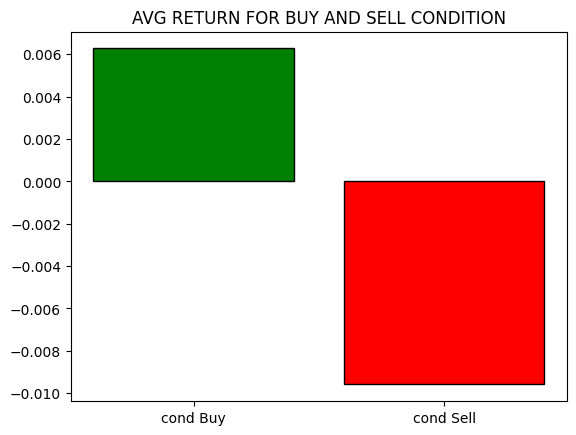

CURRENT CONDITION:  CURRENT: condition_sell


In [663]:
# ASSETS PERFORMANCE IN EACH QUAD BAR CHART
# create sample data
categories = ['cond Buy', 'cond Sell']
values = [cyc_cond_1_perf_avg, cyc_cond_2_perf_avg]

# create the plot
plt.bar(categories, values, color=['green', 'red'], edgecolor='black')

# add x-axis ticks and labels
plt.xticks(categories)

# add a title
plt.title('AVG RETURN FOR BUY AND SELL CONDITION')

# display the plot
plt.show()
print('CURRENT CONDITION: ', condition_2)

Sharpe Ratio: 0.2671870215459252
Sharpe Ratio: 0.34831854932412437


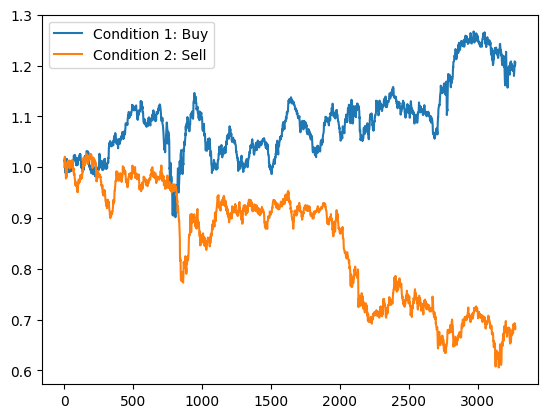

In [664]:
import matplotlib.pyplot as plt

# EQUITY CURVE
# buy_perf.plot()
#cyc_cond_1_perf = []
#cyc_cond_2_perf = []
#cyc_cond_1_perf = pd.DataFrame(cyc_cond_1_perf)
#cyc_cond_2_perf = pd.DataFrame(cyc_cond_2_perf)
# cumulative returns
cyc_cond_1_perf['cumulative_returns'] = np.cumsum(cyc_cond_1_perf[asset]) + 1
cyc_cond_2_perf['cumulative_returns'] = np.cumsum(cyc_cond_2_perf[asset]) + 1

plt.plot(cyc_cond_1_perf['cumulative_returns'], label='Condition 1: Buy')
plt.plot(cyc_cond_2_perf['cumulative_returns'], label='Condition 2: Sell')

plt.legend()  # add legend to the chart

# SHARPE RATIO
# Calculate daily returns
daily_returns = cyc_cond_1_perf['cumulative_returns'].pct_change()
daily_returns_short = -cyc_cond_2_perf['cumulative_returns'].pct_change()
# Calculate average daily return and standard deviation of daily return
avg_daily_return = daily_returns.mean()
std_daily_return = daily_returns.std()

avg_daily_return_short = daily_returns_short.mean()
std_daily_return_short = daily_returns_short.std()

# Calculate Sharpe Ratio
sharpe_ratio = np.sqrt(365) * (avg_daily_return / std_daily_return)
sharpe_ratio_short = np.sqrt(365) * (avg_daily_return_short / std_daily_return_short)

print("Sharpe Ratio:", sharpe_ratio)
print("Sharpe Ratio:", sharpe_ratio_short)



C:\Users\Christopher!\AppData\Local\Temp\ipykernel_25944\3761988318.py:6: RuntimeWarning: invalid value encountered in true_divide
  drawdown = (cumulative_returns - peak) / peak


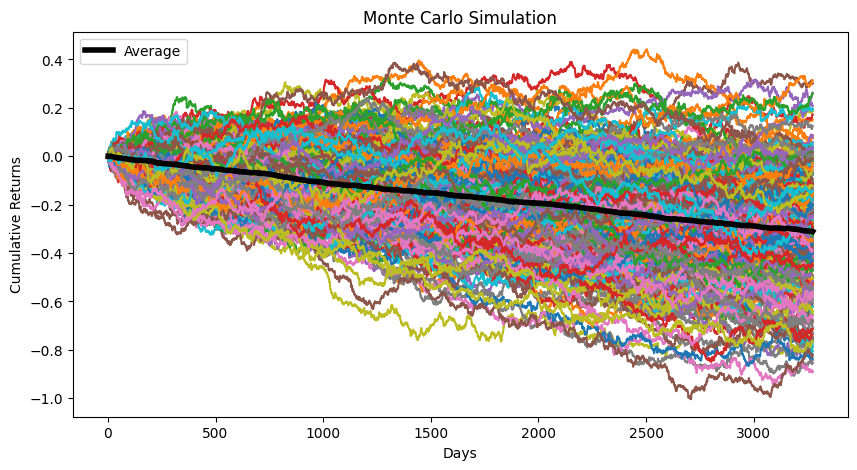

Total Trades: 3274
Number of Simulations: 300
End Performance (mean): -0.27
End Performance (max): 0.33
End Performance (min): -0.60
Win Rate (mean): 47.54%
Win Rate (max): 49.76%
Win Rate (min): 44.69%
Max Drawdown (long positions): -1456.11%
Avg Drawdown (long positions): -680.98%
Max Drawup (short positions): 4683977412.92%
Avg Drawup (short positions): 1805135269.87%
Sharpe Ratio: -1.24
Sortino Ratio: -444.96


In [665]:
# MONTE CARLO TEST

# function to calculate drawdowns in percentage terms
def calculate_drawdowns_pct(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    return drawdown

# monte carlo performance of asset curve in environment
################################
returns = cyc_cond_2_perf[asset]
#################################


# define parameters
num_simulations = 300
trades_per_simulation = len(returns)
end_performance = np.zeros(num_simulations)
win_rates = np.zeros(num_simulations)
max_peak = np.zeros(num_simulations)
avg_peak = np.zeros(num_simulations)

# run monte carlo simulation
simulated_returns = np.zeros((num_simulations, trades_per_simulation))
for i in range(num_simulations):
    sample_returns = returns.sample(n=trades_per_simulation, replace=True)
    cumulative_returns = np.cumprod(1 + sample_returns) - 1
    end_performance[i] = cumulative_returns.iloc[-1]
    win_rates[i] = np.sum(sample_returns > 0) / trades_per_simulation
    
    # calculate cumulative returns for 30 days
    returns_30_days = sample_returns.iloc[:30]
    cumulative_returns_30_days = np.cumprod(1 + returns_30_days) - 1
    avg_cumulative_return_30_days = np.mean(cumulative_returns_30_days)
    
    # calculate cumulative returns for 90 days
    returns_90_days = sample_returns.iloc[:90]
    cumulative_returns_90_days = np.cumprod(1 + returns_90_days) - 1
    avg_cumulative_return_90_days = np.mean(cumulative_returns_90_days)
    
    simulated_returns[i,:] = np.cumsum(sample_returns)

# calculate average simulation curve
mean_cumulative_returns = np.mean(simulated_returns, axis=0)

# calculate drawdowns for each simulation
simulated_drawdowns = np.apply_along_axis(calculate_drawdowns_pct, 1, simulated_returns)

# calculate drawdowns for long positions
cum_returns = np.cumprod(1 + returns) - 1
high_watermark = np.maximum.accumulate(cum_returns)
drawdown = (cum_returns - high_watermark) / np.maximum(high_watermark, 1e-8)
max_drawdown = np.min(drawdown)
avg_drawdown = np.mean(drawdown)

# calculate drawups for short positions
cum_returns = np.cumprod(1 - returns) - 1  # take the opposite of sample returns
low_watermark = np.minimum.accumulate(cum_returns)  # replace maximum with minimum
drawup = (cum_returns - low_watermark) / np.maximum(low_watermark, 1e-8)  # replace drawdown with drawup
max_drawup = np.max(drawup)  # replace min with max
avg_drawup = np.mean(drawup)  # use the mean function as is

# calculate Sharpe ratio
daily_returns = returns.mean() / returns.std()
sharpe_ratio = np.sqrt(trades_per_simulation) * daily_returns

# calculate Sortino ratio
downside_returns = returns.where(returns < 0, 0)
downside_std = downside_returns.std()
sortino_ratio = np.sqrt(trades_per_simulation) * daily_returns / downside_std


# plot results
fig, ax = plt.subplots(figsize=(10,5))
for i in range(num_simulations):
    ax.plot(range(1, trades_per_simulation+1), simulated_returns[i,:])
ax.plot(range(1, trades_per_simulation+1), mean_cumulative_returns, linewidth=4, color='k', label='Average')
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Monte Carlo Simulation')
ax.legend()
plt.show()

# print statistics
print(f"Total Trades: {trades_per_simulation}")
print(f"Number of Simulations: {num_simulations}")
print(f"End Performance (mean): {np.mean(end_performance):.2f}")
print(f"End Performance (max): {np.max(end_performance):.2f}")
print(f"End Performance (min): {np.min(end_performance):.2f}")
print(f"Win Rate (mean): {np.mean(win_rates)*100:.2f}%")
print(f"Win Rate (max): {np.max(win_rates)*100:.2f}%")
print(f"Win Rate (min): {np.min(win_rates)*100:.2f}%")
print(f"Max Drawdown (long positions): {max_drawdown:.2%}")
print(f"Avg Drawdown (long positions): {avg_drawdown:.2%}")
print(f"Max Drawup (short positions): {max_drawup:.2%}")
print(f"Avg Drawup (short positions): {avg_drawup:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")


## FINAL ENVIRONMENT

In [673]:
# CONCENSUS

print('indicator condition', condition)
print('Cyclical Condition:', condition_2)
print('if both have positive return then buy')
print('if both have negative return then sell')

indicator condition CURRENT: condition_2
Cyclical Condition: CURRENT: condition_sell
if both have positive return then buy
if both have negative return then sell


## COMBINING THE TWO INDICATORS

In [702]:
# Filter the asset data based on the common dates

# changing the data structure
#indicators : roc and vol
condition_1_data_df = pd.DataFrame(condition_1_data)
condition_2_data_df = pd.DataFrame(condition_2_data)
condition_3_data_df = pd.DataFrame(condition_3_data)
condition_4_data_df = pd.DataFrame(condition_4_data)

#cyclcial indicator
cycle_buy_data_df = pd.DataFrame(cycle_buy_data)
cycle_sell_data_df = pd.DataFrame(cycle_sell_data)

# selecting the common dates between the two environments
combined_df = pd.merge(condition_2_data, cycle_sell_data, left_index=True, right_index=True)
asset_returns_combined = df_asset.loc[combined_df.index, asset]

# calculation for calculating days of signal
asset_returns_combined_df = asset_returns_combined.asfreq('D')

In [703]:
environ_1 = ((asset_returns_combined - asset_returns_combined.shift(1)) / asset_returns_combined.shift(1))


# convert date column to datetime format
environ_1['date'] = pd.to_datetime(environ_1.index)


environ_1 = pd.DataFrame(environ_1)


environ_1['date'] = environ_1.index


environ_1 = environ_1.drop(environ_1.index[-1])


environ_1['date'] = pd.to_datetime(environ_1['date'])


environ_1['diff'] = (environ_1['date'] - environ_1['date'].shift(1)).dt.days != 1


# filter out the rows where the diff column is True
environ_1 = environ_1.loc[~environ_1['diff'], ['date', asset]]


#drop date column 
environ_1 = environ_1.drop('date', axis = 1)


# replace with incrementing numbers so its all consecutive
environ_1 = environ_1.reset_index(drop=True)


# calculate avg return
environ_1_avg = environ_1.mean() * 100


#convert to float
environ_1_avg = float(environ_1_avg)


print('ENVIRONMENT DAILY AVG RETURN:', environ_1_avg)


ENVIRONMENT DAILY AVG RETURN: 0.058904971643090866


Sharpe Ratio: 1.8864534260370005


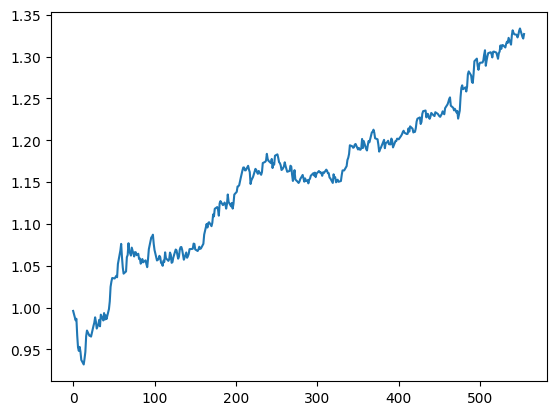

In [704]:
environ_1['cumulative_returns'] = np.cumsum(environ_1[asset]) + 1
environ_1['cumulative_returns'].plot()

# SHARPE RATIO
# Calculate daily returns
daily_returns_environ = environ_1['cumulative_returns'].pct_change()

# Calculate average daily return and standard deviation of daily return
avg_daily_returns_environ_return = daily_returns_environ.mean()
std_daily_returns_environ_return = daily_returns_environ.std()

# Calculate Sharpe Ratio
sharpe_ratio_environ = np.sqrt(252) * (avg_daily_returns_environ_return / std_daily_returns_environ_return)

print("Sharpe Ratio:", sharpe_ratio_environ)

In [705]:
# AVERAGE NUMBER OF CONSECUTIVE DAYS FOR SIGNAL
environ_data_freq = asset_returns_combined.asfreq('D')
#buy_data_freq
# initialize variables
consec_counts = []
consec_count = 0

def get_avg_consec_count(environ_data_freq):
    consec_counts = []
    consec_count = 0
    for val in environ_data_freq:
        if pd.notnull(val):
            consec_count += 1
        else:
            if consec_count > 0:
                consec_counts.append(consec_count)
                consec_count = 0
    if consec_count > 0:
        consec_counts.append(consec_count)
    if len(consec_counts) > 0:
        return sum(consec_counts) / len(consec_counts)
    else:
        return 0

avg_environ_data_freq = get_avg_consec_count(environ_data_freq)

# print the average number of consecutive non-null values
print('AVG Number of Consecutive Buy days for signal:\n', avg_environ_data_freq)

AVG Number of Consecutive Buy days for signal:
 10.910714285714286


In [706]:
last_nan_date = asset_returns_combined_df.index[asset_returns_combined_df.isnull()].max()
days_since_last_nan = (end - last_nan_date).days
print('Date of environment start:', last_nan_date)
print('Days since environment start:', days_since_last_nan)

Date of environment start: 2023-03-18 00:00:00
Days since environment start: 32


C:\Users\Christopher!\AppData\Local\Temp\ipykernel_25944\2435443884.py:6: RuntimeWarning: invalid value encountered in true_divide
  drawdown = (cumulative_returns - peak) / peak
C:\Users\Christopher!\AppData\Local\Temp\ipykernel_25944\2435443884.py:6: RuntimeWarning: divide by zero encountered in true_divide
  drawdown = (cumulative_returns - peak) / peak


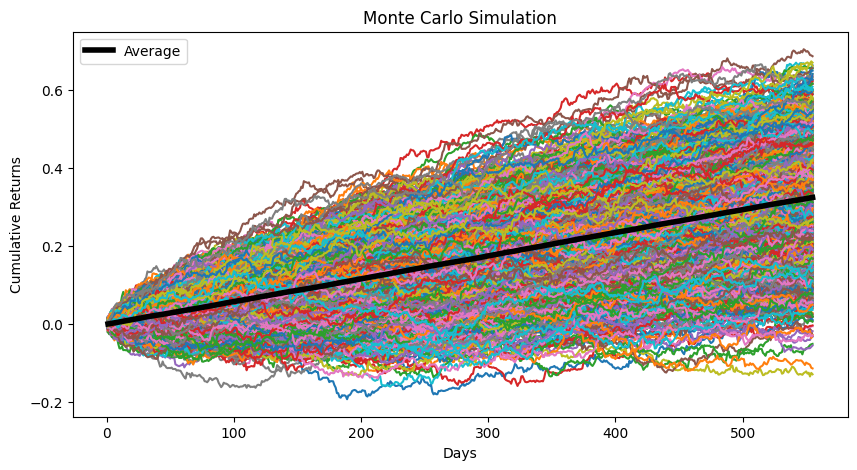

Total Trades: 555
Number of Simulations: 3000
End Performance (mean): 0.38
End Performance (max): 0.97
End Performance (min): -0.13
Win Rate (mean): 55.63%
Win Rate (max): 62.70%
Win Rate (min): 49.01%
Max Drawdown (long positions): -621436693.28%
Avg Drawdown (long positions): -18876646.15%
Max Drawup (short positions): 345229366.63%
Avg Drawup (short positions): 89313388.35%
Sharpe Ratio: 2.81
Sortino Ratio: 1021.11


In [707]:
# MONTE CARLO TEST

# function to calculate drawdowns in percentage terms
def calculate_drawdowns_pct(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    return drawdown

# monte carlo performance of asset curve in environment
################################
returns = environ_1[asset]
#################################


# define parameters
num_simulations = 3000
trades_per_simulation = len(returns)
end_performance = np.zeros(num_simulations)
win_rates = np.zeros(num_simulations)
max_peak = np.zeros(num_simulations)
avg_peak = np.zeros(num_simulations)

# run monte carlo simulation
simulated_returns = np.zeros((num_simulations, trades_per_simulation))
for i in range(num_simulations):
    sample_returns = returns.sample(n=trades_per_simulation, replace=True)

    
    cumulative_returns = np.cumprod(1 + sample_returns) - 1
    end_performance[i] = cumulative_returns.iloc[-1]
    win_rates[i] = np.sum(sample_returns > 0) / trades_per_simulation
    
    # calculate cumulative returns for 30 days
    returns_30_days = sample_returns.iloc[:30]
    cumulative_returns_30_days = np.cumprod(1 + returns_30_days) - 1
    avg_cumulative_return_30_days = np.mean(cumulative_returns_30_days)
    
    # calculate cumulative returns for 90 days
    returns_90_days = sample_returns.iloc[:90]
    cumulative_returns_90_days = np.cumprod(1 + returns_90_days) - 1
    avg_cumulative_return_90_days = np.mean(cumulative_returns_90_days)
    
    simulated_returns[i,:] = np.cumsum(sample_returns)

# calculate average simulation curve
mean_cumulative_returns = np.mean(simulated_returns, axis=0)

# calculate drawdowns for each simulation
simulated_drawdowns = np.apply_along_axis(calculate_drawdowns_pct, 1, simulated_returns)

# calculate drawups for short positions
cum_returns = np.cumprod(1 - returns) - 1  # take the opposite of sample returns
low_watermark = np.minimum.accumulate(cum_returns)  # replace maximum with minimum
drawup = (cum_returns - low_watermark) / np.maximum(low_watermark, 1e-8)  # replace drawdown with drawup
max_drawup = np.max(drawup)  # replace min with max
avg_drawup = np.mean(drawup)  # use the mean function as is

# calculate Sharpe ratio
daily_returns = returns.mean() / returns.std()
sharpe_ratio = np.sqrt(trades_per_simulation) * daily_returns

# calculate Sortino ratio
downside_returns = returns.where(returns < 0, 0)
downside_std = downside_returns.std()
sortino_ratio = np.sqrt(trades_per_simulation) * daily_returns / downside_std


# plot results
fig, ax = plt.subplots(figsize=(10,5))
for i in range(num_simulations):
    ax.plot(range(1, trades_per_simulation+1), simulated_returns[i,:])
ax.plot(range(1, trades_per_simulation+1), mean_cumulative_returns, linewidth=4, color='k', label='Average')
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Monte Carlo Simulation')
ax.legend()
plt.show()

# print statistics
print(f"Total Trades: {trades_per_simulation}")
print(f"Number of Simulations: {num_simulations}")
print(f"End Performance (mean): {np.mean(end_performance):.2f}")
print(f"End Performance (max): {np.max(end_performance):.2f}")
print(f"End Performance (min): {np.min(end_performance):.2f}")
print(f"Win Rate (mean): {np.mean(win_rates)*100:.2f}%")
print(f"Win Rate (max): {np.max(win_rates)*100:.2f}%")
print(f"Win Rate (min): {np.min(win_rates)*100:.2f}%")
print(f"Max Drawdown (long positions): {max_drawdown:.2%}")
print(f"Avg Drawdown (long positions): {avg_drawdown:.2%}")
print(f"Max Drawup (short positions): {max_drawup:.2%}")
print(f"Avg Drawup (short positions): {avg_drawup:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")

In [821]:
import pandas as pd
import numpy as np

# assume daily_returns is a pandas dataframe containing daily returns data
daily_returns = environ_1[asset]

# Set simulation parameters
num_simulations = 1000
num_days = len(daily_returns)

#exponential
# Calculate cumulative returns
#cumulative_returns = (1 + daily_returns).cumprod()

#additive
cumulative_returns = daily_returns.cumsum()


# Create a list to store simulation results
simulation_results = []

# made df
simulation_returns_df = []
simulation_returns_df = pd.DataFrame(simulation_returns_df)

# Run Monte Carlo simulations
for i in range(num_simulations):
    # Generate random indices to select a subset of data for simulation
    random_indices = np.random.choice(num_days, num_days)
    simulation_returns = cumulative_returns.iloc[random_indices].pct_change()

    # Append simulation results to dataframe
    col_name = f'Simulation {i+1}'
    simulation_returns_df[col_name] = simulation_returns.values
    

    # Calculate drawdowns
    drawdowns = (cumulative_returns.iloc[random_indices].cummax() - cumulative_returns.iloc[random_indices]) / cumulative_returns.iloc[random_indices].cummax()
    max_drawdown = drawdowns.max() * 100
    avg_drawdown = drawdowns.mean() * 100
    
    # Calculate drawups
    drawups = (cumulative_returns.iloc[random_indices] - cumulative_returns.iloc[random_indices].cummin()) / cumulative_returns.iloc[random_indices].cummin()
    max_drawup = drawups.max() * 100
    avg_drawup = drawups.mean() * 100
    
    # Calculate win rate
    num_positive_returns = len(simulation_returns[simulation_returns > 0])
    win_rate = num_positive_returns / num_days * 100
    
    # Calculate Sharpe ratio
    sharpe_ratio = simulation_returns.mean() / simulation_returns.std()
    
    # Calculate Calmar ratio
    calmar_ratio = simulation_returns.mean() / max_drawdown
    
    # Calculate average performance over specified periods
    performance_10 = (cumulative_returns.iloc[random_indices[-10]] / cumulative_returns.iloc[random_indices[0]] - 1) * 100
    performance_20 = (cumulative_returns.iloc[random_indices[-20]] / cumulative_returns.iloc[random_indices[0]] - 1) * 100
    performance_30 = (cumulative_returns.iloc[random_indices[-30]] / cumulative_returns.iloc[random_indices[0]] - 1) * 100
    
    # Store simulation results in a dictionary
    simulation_results.append({
        'max_drawdown': max_drawdown,
        'avg_drawdown': avg_drawdown,
        'max_drawup': max_drawup,
        'avg_drawup': avg_drawup,
        'win_rate': win_rate,
        'sharpe_ratio': sharpe_ratio,
        'calmar_ratio': calmar_ratio,
        'performance_10': performance_10,
        'performance_20': performance_20,
        'performance_30': performance_30
    })

simulation_results_df_cum = simulation_returns_df.cumsum()

# Convert simulation results to a pandas dataframe
simulation_results_df = pd.DataFrame(simulation_results)

# Print summary statistics
print('Max drawdown:', round(simulation_results_df['max_drawdown'].max(), 2), '%')
print('Avg drawdown:', round(simulation_results_df['avg_drawdown'].mean(), 2), '%')
print('Max drawup:', round(simulation_results_df['max_drawup'].max(), 2), '%')
print('Avg drawup:', round(simulation_results_df['avg_drawup'].mean(), 2), '%')
print('Win rate:', round(simulation_results_df['win_rate'].mean(), 2), '%')
print('Avg Sharpe ratio:', round(simulation_results_df['sharpe_ratio'].mean(), 2))
print('Avg Calmar ratio:', round(simulation_results_df['calmar_ratio'].mean(), 2))
print('Avg performance (10 days):', round(simulation_results_df['performance_10'].mean(), 2), '%')
print('Avg performance (20 days):', round(simulation_results_df['performance_20'].mean(), 2), '%')
print('Avg performance (30 days):', round(simulation_results_df['performance_30'].mean(), 2), '%')



C:\Users\Christopher!\AppData\Local\Temp\ipykernel_25944\3091203689.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simulation_returns_df[col_name] = simulation_returns.values
C:\Users\Christopher!\AppData\Local\Temp\ipykernel_25944\3091203689.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simulation_returns_df[col_name] = simulation_returns.values
C:\Users\Christopher!\AppData\Local\Temp\ipykernel_25944\3091203689.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

Max drawdown: 182.03 %
Avg drawdown: 52.94 %
Max drawup: 4333.46 %
Avg drawup: -374.87 %
Win rate: 42.39 %
Avg Sharpe ratio: -0.12
Avg Calmar ratio: -0.01
Avg performance (10 days): -88.96 %
Avg performance (20 days): -70.76 %
Avg performance (30 days): -67.7 %


C:\Users\Christopher!\AppData\Local\Temp\ipykernel_25944\3091203689.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simulation_returns_df[col_name] = simulation_returns.values
C:\Users\Christopher!\AppData\Local\Temp\ipykernel_25944\3091203689.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simulation_returns_df[col_name] = simulation_returns.values
C:\Users\Christopher!\AppData\Local\Temp\ipykernel_25944\3091203689.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

C:\Users\Christopher!\AppData\Local\Temp\ipykernel_25944\3363290513.py:29: RuntimeWarning: divide by zero encountered in true_divide
  drawdown = (high_watermark - cumulative_returns[i, :]) / high_watermark
C:\Users\Christopher!\AppData\Local\Temp\ipykernel_25944\3363290513.py:29: RuntimeWarning: invalid value encountered in true_divide
  drawdown = (high_watermark - cumulative_returns[i, :]) / high_watermark


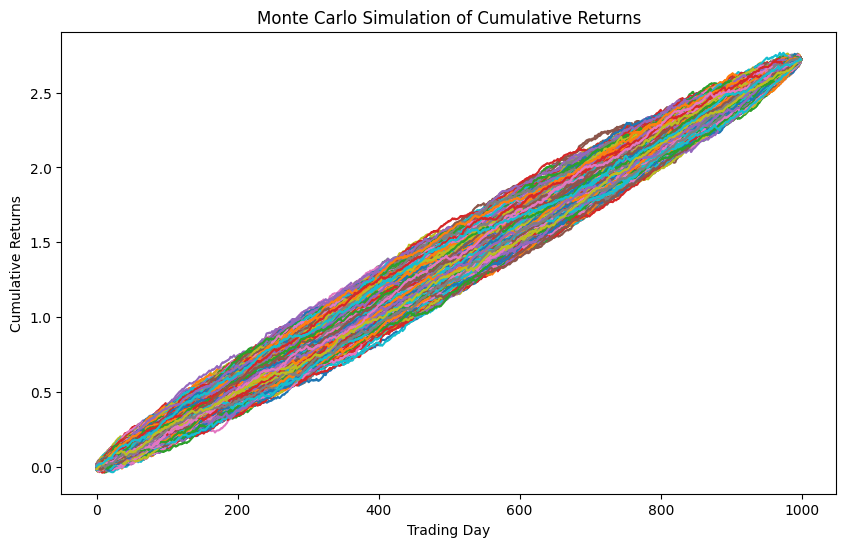

Average % Positive Returns over all Simulations: 100.00%
Average Drawdown % over all Simulations: 0.08%
Maximum Drawdown % over all Simulations: nan%
Average Drawup % over all Simulations: -0.08%
Maximum Drawup % over all Simulations: -0.00%
Average Sharpe Ratio over all Simulations: 19.64
Average Return to Drawdown over all Simulations: 3.56
Average Return to Drawup over all Simulations: -3.56


In [861]:
import numpy as np
import matplotlib.pyplot as plt

# Set the number of simulations and the number of trading days in each simulation
num_simulations = 10000
num_trading_days = len(daily_returns)

# Create an array to store the cumulative returns of each simulation
cumulative_returns = np.zeros((num_trading_days, num_simulations))

# Run the simulations
for i in range(num_simulations):
    # Shuffle the daily returns randomly
    returns_sample = np.random.permutation(daily_returns)
    
    # Calculate the cumulative returns using cumsum
    cumulative_returns[:, i] = np.cumsum(returns_sample)
    
# Calculate the average % positive returns over all simulations
positive_returns = cumulative_returns[-1, :] > 0
avg_positive_returns = np.mean(positive_returns)

# Calculate the average drawdown % over all simulations
high_watermark = np.zeros(num_simulations)
drawdown = np.zeros(num_simulations)
max_drawdown = np.zeros(num_simulations)
for i in range(num_trading_days):
    high_watermark = np.maximum(high_watermark, cumulative_returns[i, :])
    drawdown = (high_watermark - cumulative_returns[i, :]) / high_watermark
    max_drawdown = np.maximum(max_drawdown, drawdown)
avg_drawdown = np.mean(drawdown)

# Calculate the maximum drawdown % over all simulations
max_drawdown_percent = np.max(max_drawdown)

# Calculate the average drawup % over all simulations
drawup = -drawdown
avg_drawup = np.mean(drawup)

# Calculate the maximum drawup % over all simulations
max_drawup_percent = np.max(drawup)

# Calculate the average Sharpe ratio over all simulations
daily_risk_free_rate = 0.0 # Replace this with your actual risk-free rate
daily_mean_returns = np.mean(daily_returns)
daily_std_returns = np.std(daily_returns)
sharpe_ratio = np.sqrt(num_trading_days) * (daily_mean_returns - daily_risk_free_rate) / daily_std_returns
avg_sharpe_ratio = np.mean(sharpe_ratio)

# Calculate the average return to drawdown over all simulations
avg_return_to_drawdown = daily_mean_returns / avg_drawdown

# Calculate the average return to drawup over all simulations
avg_return_to_drawup = daily_mean_returns / avg_drawup

# Plot the equity curves
plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    plt.plot(cumulative_returns[:, i])
plt.xlabel('Trading Day')
plt.ylabel('Cumulative Returns')
plt.title('Monte Carlo Simulation of Cumulative Returns')
plt.show()

# Print the calculated values
print("Average % Positive Returns over all Simulations: {:.2%}".format(avg_positive_returns))
print("Average Drawdown % over all Simulations: {:.2%}".format(avg_drawdown))
print("Maximum Drawdown % over all Simulations: {:.2%}".format(max_drawdown_percent))
print("Average Drawup % over all Simulations: {:.2%}".format(avg_drawup))
print("Maximum Drawup % over all Simulations: {:.2%}".format(max_drawup_percent))
print("Average Sharpe Ratio over all Simulations: {:.2f}".format(avg_sharpe_ratio))
print("Average Return to Drawdown over all Simulations: {:.2f}".format(avg_return_to_drawdown))
print("Average Return to Drawup over all Simulations: {:.2f}".format(avg_return_to_drawup))


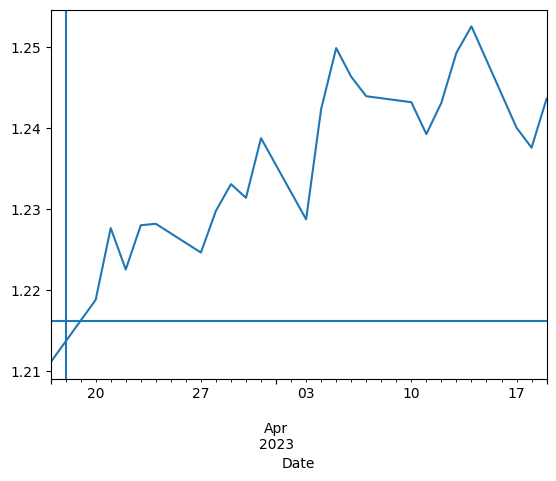

In [743]:
# create a thingy where we use the starting price of the signal that day and see where price is now from it, plus add a horizontal line where the signal price started to show relaiton of where it is now
# number of days since start of environment
#days_since_last_nan

# price that day
row_number = len(df_asset[asset]) - days_since_last_nan
price_at_signal = df_asset[asset].iloc[row_number]
price_at_signal

## drawing plot
df_asset[asset].tail(days_since_last_nan + 2).plot()
plt.axhline(price_at_signal)
plt.axvline(last_nan_date)